## Installation

In [ ]:
# https://huggingface.co/transformers/
!pip install transformers

In [ ]:
# TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds

# HuggingFace NLP library
from transformers import TFBertForSequenceClassification, BertTokenizer

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime

## Check TensorFlow and GPU

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Import Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/BryanT05/Machine-Learning-Bootcamp/main/IMDB%20Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df['review']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [ ]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
df['sentiment'] = df['sentiment'].astype('category').cat.codes
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000,)
(10000,)
(40000,)
(10000,)


In [ ]:
y_train.value_counts()

1    20000
0    20000
Name: sentiment, dtype: int64

In [ ]:
y_test.value_counts()

1    5000
0    5000
Name: sentiment, dtype: int64

In [ ]:
train = pd.DataFrame({'text': X_train, 'label': y_train})
test = pd.DataFrame({'text': X_test, 'label': y_test})

In [ ]:
train.to_csv('IMDB_train.csv', index=False)
test.to_csv('IMDB_test.csv', index=False)

## Visualize Data

In [ ]:
TRAIN_FILE_PATH = 'IMDB_train.csv'
TEST_FILE_PATH = 'IMDB_test.csv'

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/data/experimental/CsvDataset

# kolum 1 string, kolum 2 integer
ds_train = tf.data.experimental.CsvDataset([TRAIN_FILE_PATH],
                                           record_defaults=[tf.constant([""], dtype=tf.string), tf.constant([0], dtype=tf.int64)],
                                           header=True)

ds_test = tf.data.experimental.CsvDataset([TEST_FILE_PATH],
                                           record_defaults=[tf.constant([""], dtype=tf.string), tf.constant([0], dtype=tf.int64)],
                                           header=True)

In [ ]:
CLASSES = ['Negative', 'Positive']

In [ ]:
for message, label in ds_train.take(5):
    print(message, label)

tf.Tensor(b'I caught this little gem totally by accident back in 1980 or \'81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). Most were somewhat amusing but THIS came on and, within seconds, the audience was in hysterics! The biggest laugh came when they showed "Princess Laia" having huge cinnamon buns instead of hair on her head. She looks at the camera, gives a grim smile and nods. That made it even funnier! You gotta see "Chewabacca" played by what looks like a Muppet! It was extremely silly and stupid...but I couldn\'t stop laughing. Most of the dialogue was drowned out because of all the laughter. Also if you know "Star Wars" pretty well it\'s even funnier--they deliberately poke fun at some of the dialogue. This REALLY works with an audience! A definite 10!', shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'I can\'t believe t

In [ ]:
for message, label in ds_test.take(5):
    print(message, label)

tf.Tensor(b'Yes, MTV there really is a way to market Daria. What started as a clever teenage angst-"comment on everything that sucks and make the viewer feel better about their sucky teenage life" sitcom now mutated into a "how you should deal with your problems"-charade. I used to watch Daria all the time and loved it. Now, sitting here after watching the so called "movie" I can only wonder what the point of this all was. Daria tells us how to lead out life in college? Excuse me? didn\'t the point Daria made every episode that what you like to do is ok, as long as it is ok with yourself no matter what the rest of the sick sad world thinks of it? This entire thing reminded me of the scene in "Reality Bites" the movie channel shows the documentry for the first time.', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the

## What happened during BERT?

In [ ]:
example_sentence = 'it is so bad. how could the movie with 5 star rating be like that.'

In [ ]:
# https://aclanthology.org/2020.aacl-main.85.pdf
MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

## Part 1: Add Special Token

Kita harus menambah token khusus ke kalimat kita. Token khusus ini adalah `[CLS]` dan `[SEP]`.

- [CLS] stands for **classification**. It is added at the beginning because the training tasks here is sentence classification. And because they need an input that can represent the meaning of the entire sentence, they introduce a new tag.
- [SEP] The **separator** token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.

Example:
- single sequence: [CLS] X [SEP]
- pair of sequences: [CLS] A [SEP] B [SEP]



In [ ]:
example_sentence_with_special_tokens = '[CLS]' + example_sentence + '[SEP]'
tokenized_sentence = tokenizer.tokenize(example_sentence_with_special_tokens)
tokenized_sentence

['[CLS]',
 'it',
 'is',
 'so',
 'bad',
 '.',
 'how',
 'could',
 'the',
 'movie',
 'with',
 '5',
 'star',
 'rating',
 'be',
 'like',
 'that',
 '.',
 '[SEP]']

## Part 2: Convert Token to Token ID

In [ ]:
vocabulary = tokenizer.get_vocab()

print(list(vocabulary.keys())[2000:2100])

['space', 'La', 'directed', 'smile', 'episode', 'hours', 'whole', '##de', '##less', 'Why', 'wouldn', 'designed', 'strong', 'training', 'changed', 'Society', 'stage', 'involved', 'hadn', 'towards', 'leading', 'police', 'eight', 'kept', 'Institute', 'study', 'largest', 'child', 'eventually', 'private', 'modern', 'Court', 'throughout', 'getting', 'originally', 'attack', '##E', 'talk', 'Great', 'longer', 'songs', 'alone', '##ine', 'wide', 'dead', 'walked', 'shot', '##ri', 'Oh', 'force', '##st', 'Art', 'today', 'friends', 'Island', 'Richard', '1989', 'center', 'construction', 'believe', 'size', 'White', 'ship', 'completed', '##B', 'gone', 'Just', 'rock', 'sat', '##R', 'radio', 'below', 'entire', 'families', 'league', 'includes', 'type', 'lived', 'official', 'range', 'hold', 'featured', 'Most', '##ter', 'president', 'passed', 'means', '##f', 'forces', 'lips', 'Mary', 'Do', 'guitar', '##ce', 'food', 'wall', 'Of', 'spent', 'Its', 'performance']


In [ ]:
example_sentence_ids = tokenizer.convert_tokens_to_ids(tokenized_sentence)

print(tokenized_sentence)
print(example_sentence_ids)

['[CLS]', 'it', 'is', 'so', 'bad', '.', 'how', 'could', 'the', 'movie', 'with', '5', 'star', 'rating', 'be', 'like', 'that', '.', '[SEP]']
[101, 1122, 1110, 1177, 2213, 119, 1293, 1180, 1103, 2523, 1114, 126, 2851, 5261, 1129, 1176, 1115, 119, 102]


In [ ]:
another_example = 'The movie is wonderful'
another_example_with_special_tokens ='[CLS]' + another_example + '[SEP]'
another_tokenized_sentence = tokenizer.tokenize(another_example_with_special_tokens)
another_example_ids = tokenizer.convert_tokens_to_ids(another_tokenized_sentence)

print(another_example)
print(another_example_with_special_tokens)
print(another_tokenized_sentence)
print(another_example_ids)

The movie is wonderful
[CLS]The movie is wonderful[SEP]
['[CLS]', 'The', 'movie', 'is', 'wonderful', '[SEP]']
[101, 1109, 2523, 1110, 7310, 102]


## Part 3: Padding

In [ ]:
MAX_LENGTH_TEST = 128

In [ ]:
len(example_sentence_ids)

19

In [ ]:
test_padding_length = MAX_LENGTH_TEST - len(example_sentence_ids)
example_sentence_ids = example_sentence_ids + (test_padding_length * [0])
example_sentence_ids

[101,
 1122,
 1110,
 1177,
 2213,
 119,
 1293,
 1180,
 1103,
 2523,
 1114,
 126,
 2851,
 5261,
 1129,
 1176,
 1115,
 119,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## Part 4: Attention Mask

Attention mask hanya untuk token non-padded (bukan token tambahan).

In [ ]:
attention_mask = [1 if token > 0 else 0 for token in example_sentence_ids]
attention_mask

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## Part 5: Token Types

Biasanya kita perlu mengurus types untuk tasks yang membutuhkan 2 kalimat sebagai input (satu kalimat kita set 0, satunya set 1). Tapi, karena kita saat ini melakukan klasifikasi, kita set 0 untuk token padded maupun non-padded.

In [ ]:
token_type_ids = [0] * MAX_LENGTH_TEST
token_type_ids

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## Part 6: Combine All Steps

In [ ]:
test_bert_input = {
    'input_ids': example_sentence_ids,
    'token_type_ids': token_type_ids,
    'attention_mask': attention_mask
}

print(test_bert_input)

{'input_ids': [101, 1122, 1110, 1177, 2213, 119, 1293, 1180, 1103, 2523, 1114, 126, 2851, 5261, 1129, 1176, 1115, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Shortcut 🥷

In [ ]:
bert_input = tokenizer.encode_plus(
    example_sentence,
    max_length=128, # max length of the text that can go to BERT
    add_special_tokens=True, # add special tokens
    pad_to_max_length=True, # add [PAD] tokens
    return_attention_mask=True, # add attention mask so model won't focus on padded tokens
    truncation=True # truncate to a maximum length specified by max_length
)

print(bert_input)

{'input_ids': [101, 1122, 1110, 1177, 2213, 119, 1293, 1180, 1103, 2523, 1114, 126, 2851, 5261, 1129, 1176, 1115, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Apply Preprocessing to Training and Testing

In [ ]:
# hitung rata-rata dan panjang maksimum dari kalimat di dataset
MAX_LENGTH = 128

In [ ]:
def convert_sentence_to_features(sentence):
    return tokenizer.encode_plus(
        sentence,
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )

In [ ]:
def map_features_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_masks,
    }, label

In [ ]:
def encode_sentences(dataset):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []

    for message, label in tfds.as_numpy(dataset):
        bert_input = convert_sentence_to_features(message.decode())
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_features_to_dict)

# Encode Dataset

In [ ]:
BATCH_SIZE = 32

# simpan buffer 10k sample dan pilih acak dari sample tsb
# analoginya wadah untuk simpan data
SHUFFLE_BUFFER_SIZE = 10000 

In [ ]:
ds_train_encoded = encode_sentences(ds_train).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
ds_test_encoded = encode_sentences(ds_test).batch(BATCH_SIZE) # test dataset engga ada efek kalau dishuffle

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
for message, label in ds_train_encoded.take(1):
    print(message, label)

{'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[ 101,  146, 1821, ..., 1105, 1242,  102],
       [ 101, 2977,  112, ..., 2799, 1267,  102],
       [ 101, 1188, 1273, ...,  140, 1818,  102],
       ...,
       [ 101, 3956,  117, ...,  189, 1713,  102],
       [ 101, 1327, 2443, ..., 1106, 2869,  102],
       [ 101, 1135,  112, ..., 1122,  117,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>} tf.Tensor(
[[0]
 [1]
 [1]
 [0]
 [1]

## Training Model 🤗

- **Epochs**: 1 epoch == 1 kali membaca semua data di dataset. Analoginya 1 putaran dalam perlombaan lari. Semakin banyak putaran, semakin familiar dengan track larinya tapi makan lebih banyak waktu.
- **Learning Rate**: learning rate adalah seberapa besar kita mengubah weights neural network. Analoginya main golf, kalau terlalu kencang bisa lewat golnya, terlalu lambat butuh beberapa kali pukulan.

In [ ]:
LEARNING_RATE = 1e-6
EPOCHS = 10

`TFBertForSequenceClassification`: BERT model transformer dari hugging face yang dapat digunakan dengan TF. 



In [ ]:
MODEL_NAME

'bert-base-cased'

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # label = total kategori target

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Configure Model

Dengan menggunakan KERAS High-Level API, kita akan mengubah:
- **Optimizer**: setiap kali model selesai membaca sebuah batch, algoritma optimizer digunakan untuk menyesuaikan weights di neural network. Contoh algoritma: ADAM (adaptive moment estimation).
- **Loss**: menghitung nilai yang harus kita minimalisir ketika training.
- **Metric**: menilai performa dari model, contoh simpel: akurasi.

So, in what ways is Momentum better than vanilla gradient descent? In this comparison on the left, you can see two advantages:
- Momentum simply moves faster (because of all the momentum it accumulates)
- Momentum has a shot at escaping local minima (because the momentum may propel it out of a local minimum). In a similar vein, as we shall see later, it will also power through plateau regions better.

[link text](https://)![](https://miro.medium.com/max/800/1*zVi4ayX9u0MQQwa90CnxVg.gif)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

## Compile Model

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metric])

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


## TensorBoard

TensorBoard berguna untuk menganalisa model dengan memberikan berbagai pengukuran dan visualisasi yang dibutuhkan untuk evaluasi model, mencari performance bottleneck, dll. 

Kita akan merekam logs di subdirektori yang memiliki timestamp, jadi kita bisa lihat visualisasi dari masing-masing run berdasarkan timestampnya.

In [ ]:
%reload_ext tensorboard

In [ ]:
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, profile_batch=0) 

In [ ]:
tensorboard_callback

## See the power of HuggingFace! 🤗

In [ ]:
history = model.fit(ds_train_encoded,
                    epochs=EPOCHS,
                    validation_data=ds_test_encoded,
                    callbacks=[tensorboard_callback])

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

## Model Evaluation Using TensorBoard

In [ ]:
%tensorboard --logdir logs/fit

## Model Evaluation

In [ ]:
_, train_acc = model.evaluate(ds_train_encoded)
_, test_acc = model.evaluate(ds_test_encoded)

print('train acc:', train_acc)
print('test acc:', test_acc)

313/313 [==============================] - 87s 279ms/step - loss: 0.3006 - accuracy: 0.8821
train acc: 0.9487000107765198
test acc: 0.882099986076355


In [ ]:
y_true = []

for message, label in tfds.as_numpy(ds_test):
    y_true.append(label)

y_pred = model.predict(ds_test_encoded)[0].argmax(axis=-1)

## Classification Report

In [ ]:
print(classification_report(y_true, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

    Negative       0.89      0.88      0.88      5000
    Positive       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Confusion Matrix

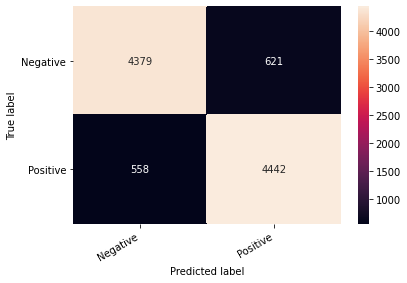

In [ ]:
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)

hmap = sns.heatmap(df_cm, annot=True, fmt='d')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/Sertifikat/

'Algorithm Intro.pdf'
'Certificate NDSC Beginner _0792-0792.pdf'
'Peserta - Webinar Save The Ocean_page-0034.jpg'


In [ ]:
model.save("/content/gdrive/MyDrive/Sertifikat/ModelIMDB")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Sertifikat/ModelIMDB/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Sertifikat/ModelIMDB/assets


##Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls /content/gdrive/MyDrive/Sertifikat/ModelIMDB/

'Algorithm Intro.pdf'
'Certificate NDSC Beginner _0792-0792.pdf'
 IMDB.pt/
 ModelIMDB/
'Peserta - Webinar Save The Ocean_page-0034.jpg'


In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Sertifikat/ModelIMDB/')

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


## Create Prediction Using API

In [ ]:
def predict(message):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []

    bert_input = convert_sentence_to_features(message)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append(2)

    ds_predict = tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_features_to_dict)
    print(ds_predict)
    predicted_probs = model.predict(ds_predict)[0]
    print(predicted_probs[0])
    predicted_idx = predicted_probs[0].argmax(axis=-1)
    predicted_label = CLASSES[predicted_idx]

    return message, predicted_label 

In [ ]:
predict("This movie is so bad")

<MapDataset shapes: ({input_ids: (128,), token_type_ids: (128,), attention_mask: (128,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


ValueError: ignored

In [ ]:
predict("this is trash")

<MapDataset shapes: ({input_ids: (128,), token_type_ids: (128,), attention_mask: (128,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>
[0.19004142 0.28993297]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('this is trash', 'Positive')

In [ ]:
predict(df.iloc[1][0])

[0.19004142 0.28993297]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well 

In [ ]:
for i in range(50):
  predict(df.iloc[i][0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28993297]
[0.19004142 0.28

In [ ]:
print(predict('This movie is shit, everyone hates it!')[1])

[0.19004142 0.28993297]
Positive


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
df.iloc[3]['review']

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [ ]:
predict("Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.")

[0.19004142 0.28993297]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


("Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",
 'Positive')